In [1]:
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from keras import layers
from keras.models import Sequential

import pandas as pd

import re
import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#reading dataset
df = pd.read_csv('TrainC.csv')  
#val_df = pd.read_excel('val.xlsx')
test_df = pd.read_csv('TestC.csv')

In [3]:
train_df=df.sample(frac = 0.25)

print('size of training set: %s' % (len(train_df['Utterance'])))
print('size of validation set: %s' % (len(test_df ['Utterance'])))


train_df.head(10)

size of training set: 3775
size of validation set: 3100


,Utterance,Intent
10169,give me a run down of my meeting schedules for...,101
2311,how do i switch out my oil,23
10652,can you book me a place to stay in denver from...,106
5034,remind me of what i asked you to remember,50
3183,would you tell me what names you have for me,31
2191,are you familiar with any types of subjects,21
2345,what is the way i can change my oil,23
947,i want to know if opening a new account will d...,9
2209,i dont have an answer for that,22
1553,has there been any changes in the status of my...,15


In [4]:
train_df["Intent"].value_counts()

21     34
52     34
100    34
95     34
74     33
       ..
147    17
122    17
27     16
99     14
71     13
Name: Intent, Length: 151, dtype: int64

In [5]:
test_df["Intent"].value_counts()

150    100
95      20
97      20
98      20
99      20
      ... 
51      20
52      20
53      20
54      20
75      20
Name: Intent, Length: 151, dtype: int64

In [6]:
from collections import Counter
Counter(test_df["Intent"])

Counter({0: 20,
         1: 20,
         2: 20,
         3: 20,
         4: 20,
         5: 20,
         6: 20,
         7: 20,
         8: 20,
         9: 20,
         10: 20,
         11: 20,
         12: 20,
         13: 20,
         14: 20,
         15: 20,
         16: 20,
         17: 20,
         18: 20,
         19: 20,
         20: 20,
         21: 20,
         22: 20,
         23: 20,
         24: 20,
         25: 20,
         26: 20,
         27: 20,
         28: 20,
         29: 20,
         30: 20,
         31: 20,
         32: 20,
         33: 20,
         34: 20,
         35: 20,
         36: 20,
         37: 20,
         38: 20,
         39: 20,
         40: 20,
         41: 20,
         42: 20,
         43: 20,
         44: 20,
         45: 20,
         46: 20,
         47: 20,
         48: 20,
         49: 20,
         50: 20,
         51: 20,
         52: 20,
         53: 20,
         54: 20,
         55: 20,
         56: 20,
         57: 20,
         58: 20,
       

In [7]:
from collections import Counter
Counter(train_df["Intent"])

Counter({101: 26,
         23: 21,
         106: 23,
         50: 22,
         31: 24,
         21: 34,
         9: 27,
         22: 25,
         15: 22,
         48: 28,
         78: 32,
         111: 23,
         125: 18,
         64: 17,
         119: 23,
         144: 28,
         18: 25,
         136: 32,
         16: 27,
         11: 22,
         25: 28,
         62: 22,
         30: 23,
         74: 33,
         20: 22,
         113: 30,
         81: 25,
         109: 24,
         130: 31,
         107: 25,
         147: 17,
         45: 28,
         110: 28,
         128: 29,
         97: 31,
         115: 29,
         24: 23,
         10: 22,
         99: 14,
         4: 27,
         60: 27,
         3: 28,
         52: 34,
         138: 22,
         14: 26,
         6: 29,
         121: 32,
         95: 34,
         79: 23,
         132: 25,
         63: 17,
         137: 24,
         149: 27,
         61: 30,
         118: 29,
         59: 26,
         36: 30,
         127: 

In [8]:
x_train, x_test, y_train, y_test = train_df["Utterance"], test_df["Utterance"], train_df["Intent"],test_df["Intent"]

In [9]:
EPOCHS= 35
act= "swish"
opt= tf.keras.optimizers.SGD(learning_rate=0.001)

In [10]:
#converting text to vectors via tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

X_train = tokenizer.texts_to_sequences(x_train)
X_test = tokenizer.texts_to_sequences(x_test)
TEST = tokenizer.texts_to_sequences(test_df["Utterance"]) 

vocab_size = len(tokenizer.word_index) + 1 

In [11]:
#calculating max length of the vector
lens_train = [len(i) for i in X_train]
lens_test = [len(i) for i in X_test]
lens = lens_train + lens_test

maxlen = np.max(lens)

print('Max len:', maxlen)

Max len: 23


In [12]:
#Zero padding every vector so that they are the same size
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
TEST = pad_sequences(TEST, padding='post', maxlen=maxlen)

In [13]:
#One Hot Encoding integer labels
dummy_y_test = np_utils.to_categorical(y_test)
dummy_y_train = np_utils.to_categorical(y_train)

In [14]:
#reading fasttext
def get_embedding_vectors(tokenizer, dim=300):
    embedding_index = {}
    with open('glove.42B.300d.txt','r', encoding="cp437", errors='ignore') as f:
        for line in tqdm.tqdm(f, "Reading Glove"):
            values = line.split()
            word = ''.join(values[:-300])
            vectors = np.asarray(values[-300:], dtype='float32')
            embedding_index[word] = vectors

    word_index = tokenizer.word_index
    embedding_matrix = np.zeros((len(word_index)+1, dim))
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            # words not found will be 0s
            embedding_matrix[i] = embedding_vector
          
    return embedding_matrix

In [15]:
embedding_matrix = get_embedding_vectors(tokenizer)

Reading Glove: 1917495it [02:28, 12897.06it/s]


In [16]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [17]:
embedding_dim = 300
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights = [embedding_matrix], input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True)),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(151, activation='softmax')
])
model.compile(optimizer=opt, loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 300)           828900    
                                                                 
 bidirectional (Bidirectiona  (None, 23, 100)          140400    
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 50)                2550      
                                                                 
 dense_1 (Dense)             (None, 151)               7701      
                                                                 
Total params: 1,009,751
Trainable params: 1,009,751
Non-trainable params: 0
______________________________________________

In [18]:
history = model.fit(X_train, dummy_y_train, epochs=EPOCHS, verbose=1, validation_data=(X_test, dummy_y_test), batch_size=8,callbacks=[callback]) 
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=0)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=0)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/35
472/472 [==============================] - 10s 16ms/step - loss: 5.0173 - accuracy: 0.0077 - val_loss: 5.0171 - val_accuracy: 0.0100
Epoch 2/35
472/472 [==============================] - 7s 15ms/step - loss: 5.0169 - accuracy: 0.0127 - val_loss: 5.0169 - val_accuracy: 0.0106
Epoch 3/35
472/472 [==============================] - 7s 15ms/step - loss: 5.0166 - accuracy: 0.0132 - val_loss: 5.0168 - val_accuracy: 0.0100
Epoch 4/35
472/472 [==============================] - 7s 14ms/step - loss: 5.0163 - accuracy: 0.0117 - val_loss: 5.0166 - val_accuracy: 0.0097
Epoch 5/35
472/472 [==============================] - 7s 14ms/step - loss: 5.0160 - accuracy: 0.0122 - val_loss: 5.0165 - val_accuracy: 0.0100
Epoch 6/35
472/472 [==============================] - 7s 14ms/step - loss: 5.0158 - accuracy: 0.0122 - val_loss: 5.0165 - val_accuracy: 0.0103
Epoch 7/35
472/472 [==============================] - 7s 14ms/step - loss: 5.0155 - accuracy: 0.0135 - val_loss: 5.0164 - val_accuracy: 0.010

In [19]:
def PlotGraph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'g', label='Training acc')
    plt.plot(x, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'g', label='Training loss')
    plt.plot(x, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

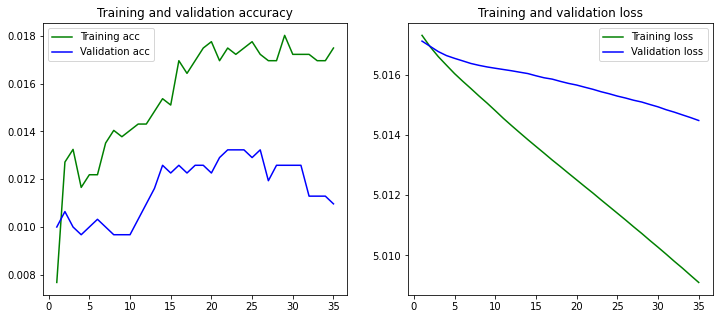

In [20]:
PlotGraph(history)